# Pathfinding demo

Pathfinding is the task of finding shortest (or any) path from one point to the other [1]. Majority of practically used pathfinding methods are based on graph search, e.g. representing the map as a graph (e.g. grid of nodes covering the map) and finding (shortest) path between nodes on this graph. Edges between the nodes may have some cost, which represents length or difficulty of getting from one node to the other.

## Brief overview of methods

### Graph-based

Before we can use graph-based search, we have to map the graph nodes and edges to the positions in the world. This may be as simple as creating regular grid, or more efficiently create nodes only in some critical points in the world map. We can also use 3D space (navmeshes in games: jumps, climbing, ...).
The less nodes there are, the faster the search.  

* Depth-first search
* Breadth-first search
    * does not take the cost into account
    * can be used to create flow fields and distance maps
    * useful for efficiently calculating paths for many agents with one destination
* Dijkstra
    * similar to BFS, but takes edge cost into account
    * prioritizes search to the direction of lesser cost
* Greedy Best-First search (GBFS)
    * similar to BFS, but uses some heuristic to prioritize search
    * this may be e.g. manhattan distance to the destination
    * may get a bit "stuck" if there are obstacles
* A*
    * combines GBFS and Dijkstra
    * priority is the sum of heuristic and the cost-so-far
    * usually the best option 

There are many possible modifications and optimizations to these methods. Graph-based methods may also be combined with non-graph ones (e.g. having one unit in RTS search the path using A*, and all the other units within a group attracted to it using potential field).

### Non-graph based

* Gradient descent
    * Optimizes paths by following the steepest descent in a potential field
* Potential field methods
    * Simulate attractive forces toward goals and repulsive forces from obstacles
* Straight-line or Euclidean paths
    * Simply connect points directly, often with collision checks; basic for open spaces but may require smoothing for obstacles.

## Selecting a method

Selecting a method depends on several factors:

* use case
   * what "world" are we navigating in: is it possible to represent it efficiently as a graph?
   * if we do just one-off calculation, or if we intend to do that very often
   * if we do "one source, one destination", "one source, all destinations", "all sources, one destination" or "all sources, all destinations" - see [this article](https://www.redblobgames.com/pathfinding/tower-defense/) 
   * if there are moving obstacles
* performance requirements: how fast we want to calculate the path, how often we do it
* memory requirements: some methods are more memory-intensive

## Sources

[[1] Wikipedia on pathfinding](https://en.wikipedia.org/wiki/Pathfinding)

[Redblobgames](https://www.redblobgames.com/) has excellent set of articles about pathfinding and other related topics for game development.

## List of implemented methods

This Python demo implements few of the described methods.

1. Breadth-first search
2. Dijkstra
3. Greedy Best-First search (GBFS)
4. A*



In [1]:
#
# Imports
#

import matplotlib.pyplot as plt
import numpy as np
import time
import random
from typing import Optional, NewType, Any
from abc import ABC, abstractmethod
from queue import Queue, PriorityQueue
from dataclasses import dataclass, field

In [2]:
#
# Type and interfaces definition
#

Point2D = NewType("Point2D", tuple[int, int])
# type Point2D = tuple[int, int] # tuple(x, y)
type Path = list[Point2D]

class Map:
    """
    2D map consisting of cells with given cost
    """
    # array not defined as private, as plotting utilities work with it directly
    array: np.ndarray
    _visited_nodes: int

    def __init__(self, width: int, height: int) -> None:
        assert width > 0
        assert height > 0
        rows = height
        cols = width
        self.array = np.zeros((rows, cols), dtype=np.float64)
        self._visited_nodes = 0

    def Randomize(self, low: float = 0.0, high: float = 1.0) -> None:
        self.array = np.random.uniform(low, high, self.array.shape)

    def IsPointValid(self, point: Point2D) -> bool:
        x, y = point
        y_max, x_max = self.array.shape
        x_in_bounds = (0 <= x < x_max) 
        y_in_bounds = (0 <= y < y_max) 
        return x_in_bounds and y_in_bounds
    
    def GetNeighbours(self, center_point: Point2D) -> list[Point2D]:
        """
        Get list of neighboring points (without actually visiting them)
        """
        points: list[Point2D] = []
        x_center, y_center = center_point
        for x in range(-1,2):
            for y in range(-1,2):
                diagonal = x == y # includes center 0,0
                if diagonal:
                    continue
                p = Point2D((x + x_center, y + y_center))
                if self.IsPointValid(p):
                    points.append(p)
        return points
    
    def GetPointCost(self, point: Point2D) -> float:
        x, y = point
        row, col = y, x
        return self.array[(row, col)]
    
    def GetPathCost(self, path: Path) -> float:
        return sum([self.GetPointCost(p) for p in path])

    def ResetVisitedCount(self) -> None:
        self._visited_nodes = 0

    def GetVisitedCount(self) -> int:
        return self._visited_nodes

    def Visit(self, point: Point2D) -> float:
        """
        Visit the node and return its cost
        """
        if not self.IsPointValid(point):
            raise ValueError("Point out of bounds")
        self._visited_nodes += 1
        return self.GetPointCost(point)

    def CreateMaze(self, wall_probability: float = 0.3) -> None:
        """
        Note: generated with Grok
        Generate a simple maze on the map.
        - Borders are set as walls (cost 1000).
        - Internal cells are randomly set to 1 (path) or 1000 (wall) based on wall_probability.

        Args:
            wall_probability (float): Probability (0-1) that an internal cell becomes a wall.
        """
        rows, cols = self.array.shape

        # Set borders to walls (cost 1000)
        self.array[0, :] = 1000  # Top row
        self.array[-1, :] = 1000  # Bottom row
        self.array[:, 0] = 1000  # Left column
        self.array[:, -1] = 1000  # Right column

        # Set internal cells randomly
        for y in range(1, rows - 1):  # Skip borders
            for x in range(1, cols - 1):
                if random.random() < wall_probability:
                    self.array[y, x] = 1000  # Wall
                else:
                    self.array[y, x] = 1  # Normal tile


In [3]:
#
# Drawing utilities
#

class Visualizer:
    _axes: Optional[plt.Axes]
    #_cmap: plt.Colormap
    _cmap_counter: int

    def __init__(self):
        self._axes = None
        self._cmap = plt.get_cmap('tab10')
        self._cmap_counter = 0

    def DrawMap(self, m: Map):
        M, N = m.array.shape
        _, ax = plt.subplots()
        ax.imshow(m.array, cmap='gist_earth', origin='lower', interpolation='none')
        self._axes = ax

    def DrawPath(self, path: Path, label: str = "Path"):

        """
        Draw path on a map. Note that DrawMap has to be called first
        """
        assert self._axes is not None, "DrawMap must be called first"
        xs, ys = zip(*path)
        color = self._cmap(self._cmap_counter)
        self._cmap_counter += 1
        self._axes.plot(xs, ys, 'o-', color=color, label=label)
        self._axes.plot(xs[0],  ys[0],  'o', color='lime',  markersize=8)  # starting point
        self._axes.plot(xs[-1], ys[-1], 'o', color='magenta', markersize=8)  # end point
        self._axes.legend()


#
# Utilities and helper classes
#

@dataclass(order=True)
class PrioritizedItem:
    """
    Helper class for wrapping items in the PriorityQueue,
    so that it can compare items with priority
    """
    item: Any = field(compare=False)
    priority: float


In [4]:
#
# Pathfinding implementations
#

class PathFinderBase(ABC):
    name: str
    _map: Optional[Map]
    _elapsed_time_ns: int
    _visited_node_count: int

    def __init__(self) -> None:
        self._map = None
        self._elapsed_time_ns = 0
        self._visited_node_count = 0


    def SetMap(self, m: Map) -> None:
        self._map = m

    def CalculatePath(self, start: Point2D, end: Point2D) -> Optional[Path]:
        """
        Calculate path on a given map.
        Note: map must be set first using SetMap
        """
        assert self._map is not None, "SetMap must be called first"
        self._map.ResetVisitedCount()
        start_time = time.perf_counter_ns()
        res = self._CalculatePath(start, end)
        stop_time = time.perf_counter_ns()
        self._elapsed_time_ns = stop_time - start_time
        self._visited_node_count = self._map.GetVisitedCount()
        return res

    @abstractmethod
    def _CalculatePath(self, start: Point2D, end: Point2D) -> Optional[Path]:
        """
        This method must be implemented by the derived classes
        """

    def GetStats(self) -> tuple[int, int]:
        """
        Return performance stats for the last calculation:
        - elapsed time in nanoseconds,
        - number of visited nodes during search
        """
        return self._elapsed_time_ns, self._visited_node_count


class BFS(PathFinderBase):
    """
    Iterative breadth-first search
    Finds optimal path and creates flow-field, does not take the node cost into account.
    This would be good match for static maps with lots of agents with one
    destination.
    Compared to A*, this is more computationally expensive if we only want
    to find path for one agent.
    """

    name = "Breadth First Search"
    # flow field and distance map
    _came_from: dict[Point2D, Point2D]
    _distance: dict[Point2D, float]

    def _CalculatePath(self, start_point: Point2D, end_point: Point2D) -> Optional[Path]:
        frontier: Queue[Point2D] = Queue()
        frontier.put(start_point)
        self._came_from: dict[Point2D, Optional[Point2D]] = { start_point: None }
        self._distance: dict[Point2D, float] = { start_point: 0.0 }

        # build flow field
        early_exit = False
        while not frontier.empty() and not early_exit:
            current = frontier.get()
            for next_point in self._map.GetNeighbours(current):
                if next_point not in self._came_from:
                    frontier.put(next_point)
                    self._distance[next_point] = self._distance[current] + 1.0
                    _ = self._map.Visit(next_point) # visit only to track visited node count
                    self._came_from[next_point] = current
                    if next_point == end_point:
                        # early exit - if you want to build the whole flow field, remove this
                        early_exit = True
                        break
        # find actual path
        path: Path = []
        current = end_point
        path.append(current)
        while self._came_from[current] is not None:
            current = self._came_from[current]
            path.append(current)
        path.reverse()
        return path


class DijkstraAlgorithm(PathFinderBase):
    """
    Dijsktra's algorithm (Uniform Cost Search)
    Like BFS, but takes into account cost of nodes
    (priority for the search being the distance from the start)
    """

    name = "Dijkstra's Algorithm"

    def _CalculatePath(self, start_point: Point2D, end_point: Point2D) -> Optional[Path]:
        frontier: PriorityQueue[PrioritizedItem] = PriorityQueue()
        came_from: dict[Point2D, Optional[Point2D]] = {start_point: None}
        cost_so_far: dict[Point2D, float] = {start_point: 0.0}

        frontier.put(PrioritizedItem(start_point, 0.0))
        while not frontier.empty():
            current = frontier.get().item
            if current == end_point:
                # early exit - remove if you want to build the whole flow map
                break
            for next_point in self._map.GetNeighbours(current):
                new_cost = cost_so_far[current] + self._map.Visit(next_point)
                if next_point not in cost_so_far or new_cost < cost_so_far[next_point]:
                    cost_so_far[next_point] = new_cost
                    priority = new_cost
                    frontier.put(PrioritizedItem(next_point, priority))
                    came_from[next_point] = current
        # build the actual path
        path: Path = []
        current = end_point
        path.append(current)
        while came_from[current] is not None:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path
        

class GBFS(PathFinderBase):
    """
    Like Dijsktra's Algorithm, but uses some heuristic as a priority 
    instead of the cost of the node
    """
    
    name = "Greedy Best First Search"

    @staticmethod
    def heuristic(a: Point2D, b: Point2D) -> float:
        x_a, y_a = a
        x_b, y_b = b
        return abs(x_a - x_b) + abs(y_a - y_b)

    def _CalculatePath(self, start_point: Point2D, end_point: Point2D) -> Optional[Path]:
        frontier: PriorityQueue[PrioritizedItem] = PriorityQueue()
        came_from: dict[Point2D, Optional[Point2D]] = {start_point: None}
        
        frontier.put(PrioritizedItem(start_point, 0.0))
        # create the flow field
        while not frontier.empty():
            current = frontier.get().item
            if current == end_point:
                # early exit
                break
            for next_point in self._map.GetNeighbours(current):
                if next_point not in came_from:
                    priority = self.heuristic(end_point, next_point)
                    frontier.put(PrioritizedItem(next_point, priority))
                    _ = self._map.Visit(next_point) # visit only to track visited node count
                    came_from[next_point] = current
        # create the actual path
        path: Path = [end_point]
        while came_from[current] is not None:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path


class A_star(PathFinderBase):
    """
    Combines Dijsktra's Algorithm and GBFS:
    priority is the sum of the heuristic and distance from the start
    """

    name = "A*"

    @staticmethod
    def heuristic(a: Point2D, b: Point2D) -> float:
        x_a, y_a = a
        x_b, y_b = b
        return abs(x_a - x_b) + abs(y_a - y_b)

    def _CalculatePath(self, start_point: Point2D, end_point: Point2D) -> Optional[Path]:
        frontier: PriorityQueue[PrioritizedItem] = PriorityQueue()
        came_from: dict[Point2D, Optional[Point2D]] = { start_point: None }
        cost_so_far: dict[Point2D, float] = { start_point: 0.0 }

        frontier.put(PrioritizedItem(start_point, 0.0))
        while not frontier.empty():
            current = frontier.get().item
            if current == end_point:
                # early exit
                break
            for next_point in self._map.GetNeighbours(current):
                new_cost = cost_so_far[current] + self._map.Visit(next_point)
                if next_point not in cost_so_far or new_cost < cost_so_far[next_point]:
                    cost_so_far[next_point] = new_cost
                    priority = new_cost + self.heuristic(end_point, next_point)
                    frontier.put(PrioritizedItem(next_point, priority))
                    came_from[next_point] = current
        # create the actual path
        path: Path = [end_point]
        current = end_point
        while came_from[current] is not None:
            current = came_from[current]
            path.append(current)
        path.reverse()
        return path



Breadth First Search    : took 2.202 ms, visited 595 nodes, cost 31016.00
Dijkstra's Algorithm    : took 2.658 ms, visited 2020 nodes, cost 2048.00
Greedy Best First Search: took 0.327 ms, visited 109 nodes, cost 31016.00
A*                      : took 1.477 ms, visited 1066 nodes, cost 2048.00


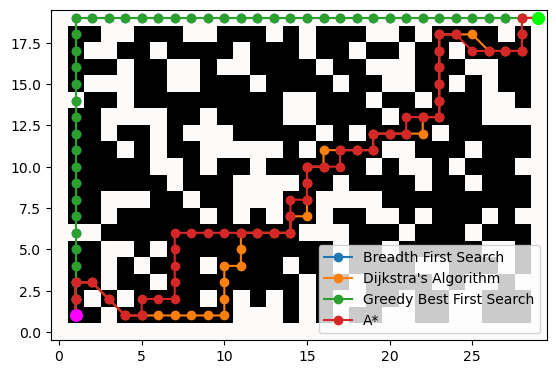

In [5]:
 # Define the map and start/stop points
m = Map(30,20)
#m.Randomize()
m.CreateMaze()
starting_point: Point2D = Point2D((29,19))
end_point: Point2D = Point2D((1,1))

path_finder_classes: list[type[PathFinderBase]] = [
    BFS,
    DijkstraAlgorithm,
    GBFS,
    A_star,
]

v = Visualizer()
v.DrawMap(m)

for pfc in path_finder_classes:
    path_finder = pfc()
    path_finder.SetMap(m)
    path = path_finder.CalculatePath(starting_point, end_point)
    elapsed_time, visited_nodes = path_finder.GetStats()
    if path is not None: 
        cost = m.GetPathCost(path)
        print(f"{path_finder.name:24}: took {elapsed_time/1e6:.3f} ms, visited {visited_nodes} nodes, cost {cost:.2f}")
        v.DrawPath(path, label=path_finder.name)
    else:
        print(f"{path_finder.name}: No path found")
